## CSV, Excel 파일 처리를 위한 Agent

Pandas DataFrame을 활용하여 분석을 수행하는 agent를 만들어 봅니다.

CSV, Excel 데이터로부터 Pandas DataFame 객체를 생성할 수 있으며, 이를 활용하여 Agent가 Pandas query를 생성하고 분석을 수행한다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("csv_excel_agent")

LangSmith 추적을 시작합니다.
[프로젝트명]
csv_excel_agent


In [38]:
import pandas as pd

df = pd.read_csv("docs/음식분류_AI_데이터_영양DB.csv")
# df2 = pd.read_excel("docs/음식분류_AI_데이터_영양DB.xlsx")

df.head() # 데이터 앞부분 확인

,음 식 명,중량(g),에너지(kcal),탄수화물(g),당류(g),지방(g),단백질(g),칼슘(mg),인(mg),나트륨(mg),칼륨(mg),마그네슘(mg),철(mg),아연(mg),콜레스테롤(mg),트랜스지방(g)
0,쌀밥,210.0,334.80,73.71,0.0,0.45,5.76,3.60,126.00,59.40,146.70,-,0.36,1.35,0.00,0.0
1,기타잡곡밥,200.0,302.36,65.52,0.0,0.75,6.71,12.06,117.84,3.39,166.72,6.90,1.74,1.83,0.00,0.0
2,콩밥,200.0,322.90,65.85,0.0,1.67,8.43,24.70,126.90,4.10,258.40,22.50,1.74,1.61,0.00,0.0
3,보리밥,200.0,316.10,70.57,0.0,0.14,5.55,6.70,68.80,4.50,100.60,0.00,1.26,1.41,0.00,0.0
4,돌솥밥,350.0,528.86,101.85,0.0,8.35,10.19,61.46,193.72,618.32,624.32,57.79,3.32,2.58,2.37,0.0


In [36]:
# df= [df1, df2] # 데이터 두개를 묶어 사용할때

In [48]:
from langchain_experimental.tools import PythonAstREPLTool

# 파이썬 코드를 실행하는 도구 생성
python_tool = PythonAstREPLTool()
# agent가 tool_calling을 할때 데이터프레임에 로드했다 가정하고 쿼리문을 만들어주기 때문에 locals의 "df"변수에 df를 할당 해야한다. 
# 만일 df가 등록이 안되어있다면 오류가 발생한다. 
python_tool.locals["df"] = df

# 도구 호출시 실행되는 콜백 함수 : 쿼리의 결과물을 출력하는 함수
def tool_callback(tool) -> None:
    print(f"\n--------------------- Code ---------------------")
    if tool_name := tool.get("tool") :          # 도구에 입력된 값이 있다면....
        if tool_name == "python_repl_ast":
            tool_input = tool.get("tool_input")
            for k, v in tool_input.items(): # 딕셔너리 형태의 값을 출력 
                # k는 key, v는 value
                if k == "query":
                    print(v) # 쿼리문 출력
                    result = python_tool.invoke({"query": v})
                    print(result)
    print(f"------------------------------------------------")

# 관찰 결과를 출력하는 콜백함수
def observation_callback(observation) -> None:
    print(f"\n----------------- Observation ------------------")
    if "observation" in observation:
        print(observation["observation"])
    print(f"------------------------------------------------\n")

# 최종 결과 출력
def result_callback(result : str) -> None:
    print(f"\n------------------- Result --------------------")
    print(result)
    print(f"------------------------------------------------")



In [51]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import AgentStreamParser, AgentCallbacks

agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o", temperature=0),
    df,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst and expert in Pandas."
    "You must use  Pandas DataFrame(`df`) to answer users request"
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code."
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code."
    "I prefer seaborn code for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",
)

parser_callback = AgentCallbacks(tool_callback, observation_callback, result_callback)

stream_parser = AgentStreamParser(parser_callback)

In [41]:
def ask(query : str) -> None:
    # 질의에 대한 답변 출력
    response = agent.stream({"input":query})
    for step in response :
        # print(step)
        # if "observation" in step:
        #     print(step["observation"])
        stream_parser.process_agent_steps(step)


--------------------- Code ---------------------
df.columns = ['Food Name', 'Weight(g)', 'Energy(kcal)', 'Carbohydrates(g)', 'Sugars(g)', 'Fat(g)', 'Protein(g)', 'Calcium(mg)', 'Phosphorus(mg)', 'Sodium(mg)', 'Potassium(mg)', 'Magnesium(mg)', 'Iron(mg)', 'Zinc(mg)', 'Cholesterol(mg)', 'Trans Fat(g)']
correlation_matrix = df.corr()
correlation_matrix
ValueError: could not convert string to float: '쌀밥'
------------------------------------------------

--------------------- Code ---------------------
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white', palette='muted')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()
ModuleNotFoundError: No module named 'seaborn'
------------------------------------------------

----------------- Observation ------------------
ValueError: could not convert string to float: '쌀밥'
------------------------------------------------


---

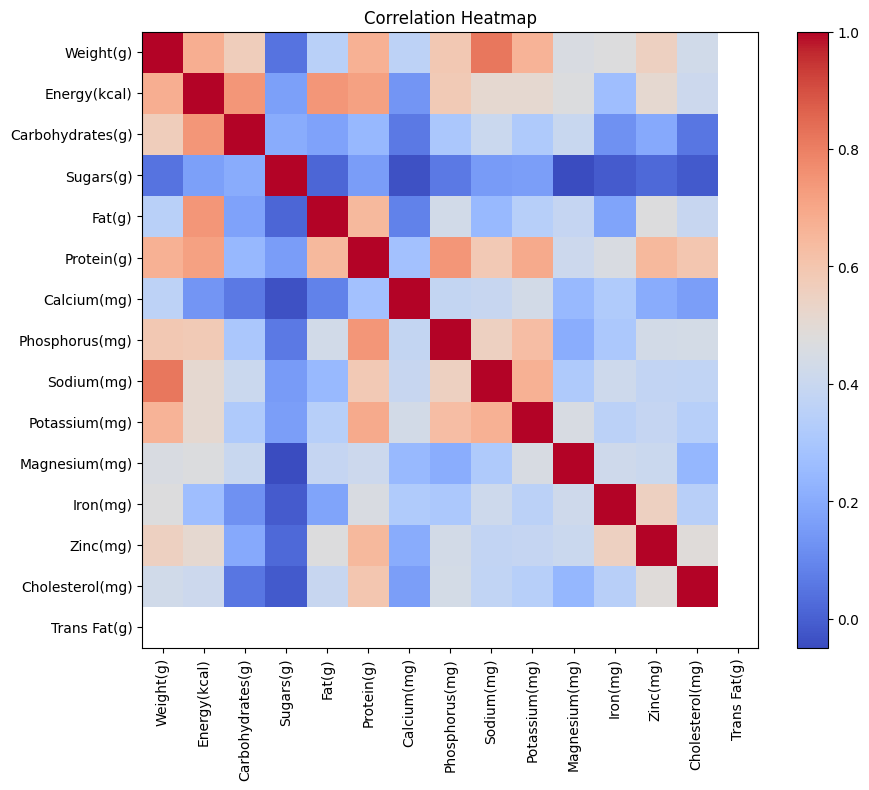


--------------------- Code ---------------------
import numpy as np

# Replace non-numeric values with NaN
numeric_df = df.drop(columns=['Food Name']).replace('-', np.nan)
correlation_matrix = numeric_df.corr()

# Use matplotlib for visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

------------------------------------------------


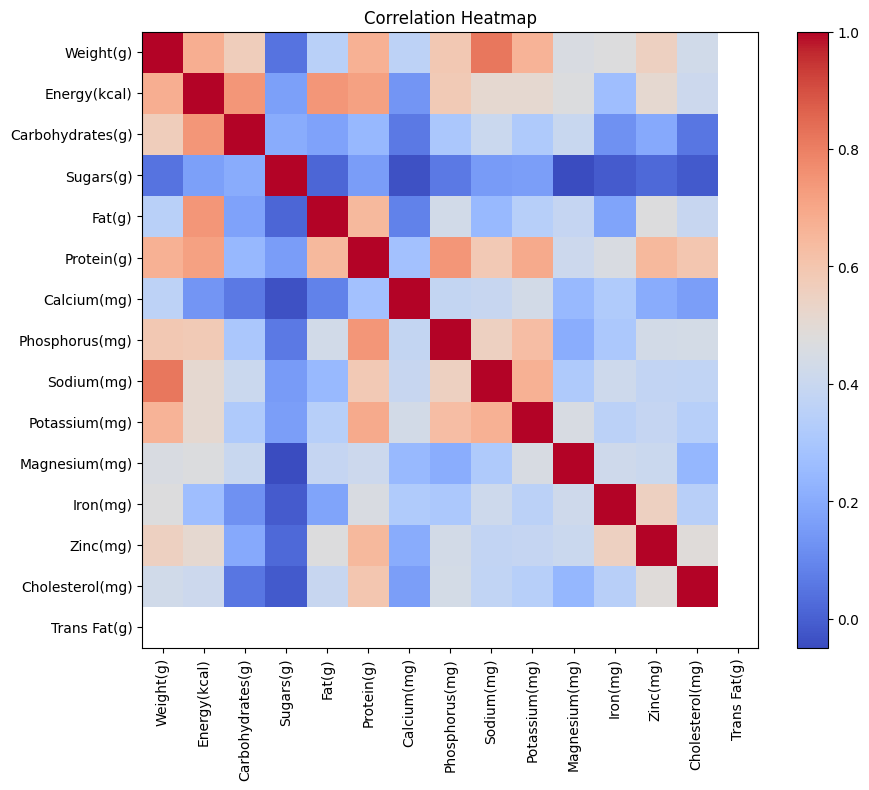


----------------- Observation ------------------

------------------------------------------------


------------------- Result --------------------
The correlation heatmap has been successfully generated using matplotlib. The non-numeric values were replaced with `NaN`, allowing the correlation calculation to proceed. If you have any further questions or need additional analysis, feel free to ask!
------------------------------------------------


In [53]:
response = agent.stream({"input": "한국어는 영어로 번역 후 corr()을 구해서 히트맵 시각화"})

for step in response : 
    # print(step)
    # if "observation" in step:
    #     print(step["observation"])
    stream_parser.process_agent_steps(step)


In [54]:
ask("몇개의 행이있어?")


--------------------- Code ---------------------
len(df)
400
------------------------------------------------

----------------- Observation ------------------
400
------------------------------------------------


------------------- Result --------------------
데이터프레임에는 총 400개의 행이 있습니다.
------------------------------------------------


In [56]:
ask("당(g)이 적당한것이 10g이라고 했을때, 당이 적은 음식들과 많은 음식들의  몇퍼센트정도 씩 차지하는지 알려줘")


--------------------- Code ---------------------
low_sugar_percentage = (df[df['당류(g)'] < 10].shape[0] / df.shape[0]) * 100
high_sugar_percentage = (df[df['당류(g)'] >= 10].shape[0] / df.shape[0]) * 100
low_sugar_percentage, high_sugar_percentage
KeyError: '당류(g)'
------------------------------------------------

----------------- Observation ------------------
KeyError: '당류(g)'
------------------------------------------------


--------------------- Code ---------------------
df.columns
Index(['Food Name', 'Weight(g)', 'Energy(kcal)', 'Carbohydrates(g)',
       'Sugars(g)', 'Fat(g)', 'Protein(g)', 'Calcium(mg)', 'Phosphorus(mg)',
       'Sodium(mg)', 'Potassium(mg)', 'Magnesium(mg)', 'Iron(mg)', 'Zinc(mg)',
       'Cholesterol(mg)', 'Trans Fat(g)'],
      dtype='object')
------------------------------------------------

----------------- Observation ------------------
Index(['Food Name', 'Weight(g)', 'Energy(kcal)', 'Carbohydrates(g)',
       'Sugars(g)', 'Fat(g)', 'Protein(g)', 'Calci


--------------------- Code ---------------------
# Calculate the percentage of foods with low carbohydrates and low fats
# Define thresholds for low carbohydrates and low fats
low_carb_threshold = 10
low_fat_threshold = 5

# Calculate the number of foods with low carbohydrates and low fats
low_carb_count = df[df['탄수화물(g)'] < low_carb_threshold].shape[0]
low_fat_count = df[df['지방(g)'] < low_fat_threshold].shape[0]

total_count = df.shape[0]

# Calculate percentages
low_carb_percentage = (low_carb_count / total_count) * 100
low_fat_percentage = (low_fat_count / total_count) * 100

low_carb_percentage, low_fat_percentage
KeyError: '탄수화물(g)'
------------------------------------------------

----------------- Observation ------------------
KeyError: '탄수화물(g)'
------------------------------------------------


--------------------- Code ---------------------
# Check the column names to ensure they are correct
column_names = df.columns
column_names
Index(['Food Name', 'Weight(g)', 'Energy(kc

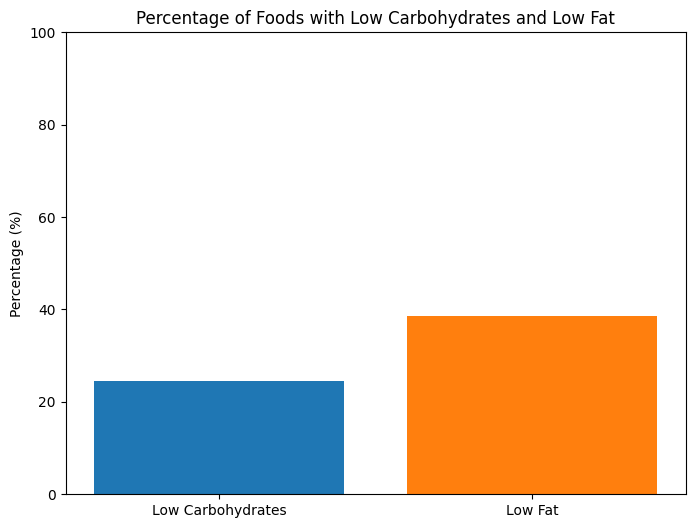

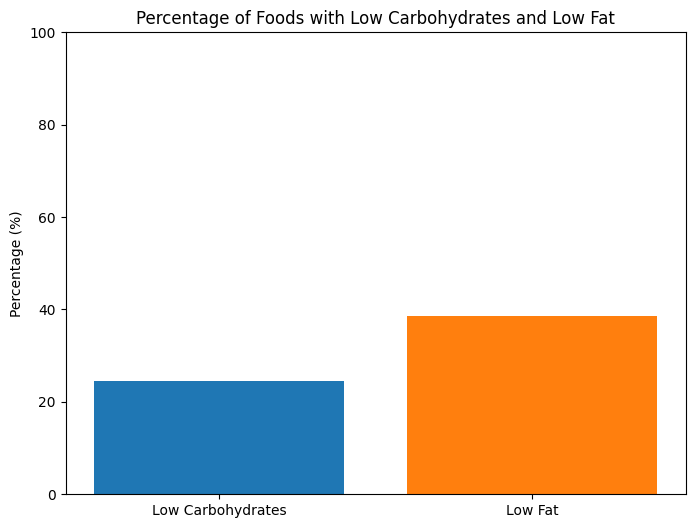


--------------------- Code ---------------------
# Fallback to matplotlib for visualization
import matplotlib.pyplot as plt

# Data for visualization
percentages = [24.5, 38.5]
labels = ['Low Carbohydrates', 'Low Fat']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['#1f77b4', '#ff7f0e'])
plt.ylabel('Percentage (%)')
plt.title('Percentage of Foods with Low Carbohydrates and Low Fat')
plt.ylim(0, 100)
plt.show()

------------------------------------------------

----------------- Observation ------------------

------------------------------------------------


------------------- Result --------------------
The percentages of foods with low carbohydrates and low fats are 24.5% and 38.5%, respectively. The bar plot visualizes these percentages.
------------------------------------------------


In [57]:
ask("탄수화물이 적은 음식과 지방이 적은음식들이 각각 몇퍼센트를 차지하는지 구하고, barplot 차트로 시각화해줘")


--------------------- Code ---------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for rows where '음 식 명' contains '밥'
rice_df = df[df['음 식 명'].str.contains('밥')]

# Count the occurrences
rice_count = rice_df.shape[0]

# Visualize the count
sns.set_theme(style="white", palette="muted")
plt.figure(figsize=(6,4))
sns.barplot(x=['밥 포함 음식'], y=[rice_count])
plt.title('Number of Foods Containing "밥"')
plt.ylabel('Count')
plt.show()

rice_count
ModuleNotFoundError: No module named 'seaborn'
------------------------------------------------

----------------- Observation ------------------
ModuleNotFoundError: No module named 'seaborn'
------------------------------------------------


--------------------- Code ---------------------
import matplotlib.pyplot as plt

# Filter the DataFrame for rows where '음 식 명' contains '밥'
rice_df = df[df['음 식 명'].str.contains('밥')]

# Count the occurrences
rice_count = rice_df.shape[0]

# Visualize the count
plt.f

/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48165 (\N{HANGUL SYLLABLE BAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Cas

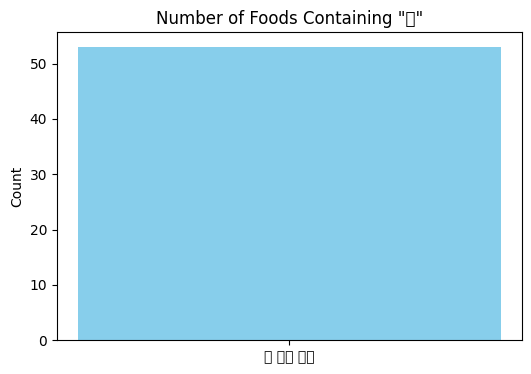

53
------------------------------------------------


/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48165 (\N{HANGUL SYLLABLE BAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/test_langchain/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Cas

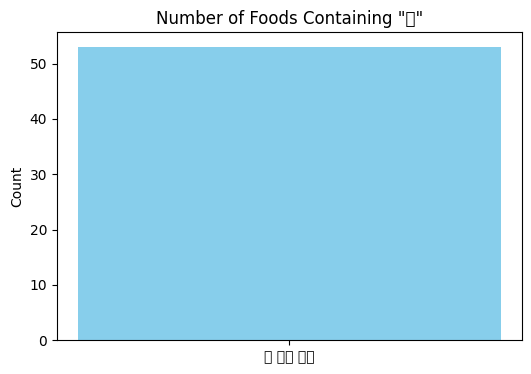


----------------- Observation ------------------
53
------------------------------------------------


------------------- Result --------------------
There are 53 food items containing the word "밥" in their names. Here is the visualization of the count:

![Number of Foods Containing "밥"](attachment://Number_of_Foods_Containing_밥.png)
------------------------------------------------


In [59]:
ask("음식명의 '밥'이라고 포함된 단어가 몇개인지 구하고 시각화해줘")

In [60]:
ask("메인 음식이 아닌 단순한 반찬종류가 어떤것들이 있어??")


--------------------- Code ---------------------
df[df['중량(g)'] < 100][['음 식 명', '중량(g)', '에너지(kcal)']].sort_values(by='에너지(kcal)')
KeyError: '중량(g)'
------------------------------------------------

----------------- Observation ------------------
KeyError: '중량(g)'
------------------------------------------------


--------------------- Code ---------------------
df.columns
Index(['Food Name', 'Weight(g)', 'Energy(kcal)', 'Carbohydrates(g)',
       'Sugars(g)', 'Fat(g)', 'Protein(g)', 'Calcium(mg)', 'Phosphorus(mg)',
       'Sodium(mg)', 'Potassium(mg)', 'Magnesium(mg)', 'Iron(mg)', 'Zinc(mg)',
       'Cholesterol(mg)', 'Trans Fat(g)'],
      dtype='object')
------------------------------------------------

----------------- Observation ------------------
Index(['Food Name', 'Weight(g)', 'Energy(kcal)', 'Carbohydrates(g)',
       'Sugars(g)', 'Fat(g)', 'Protein(g)', 'Calcium(mg)', 'Phosphorus(mg)',
       'Sodium(mg)', 'Potassium(mg)', 'Magnesium(mg)', 'Iron(mg)', 'Zinc(mg)',
       